# Simple NP chemostat model

Chemostats are a commonly used experimental setup for studying the dynamics of microorganisms under controlled laboratory settings. They are characterized by a constant inflow of medium containing nutrients and a constant outflow of the culture, both at a fixed rate $d$ [$d^{-1}$]. Under constant conditions, a steady-state emerges that is particularly useful for studying growth dynamics of microorganisms. 

Although the conditions of chemostat systems do not have a direct equivalent in nature, some oceanic upwelling systems can be approximated with such a simple model.
To showcase the flexibility and simplicity of the XSO framework, we consider two cases: (1) a constant nutrient input and (2) a sinusoidal nutrient input (time-varying $d$).

$$ 
\frac{d N}{d t} =  d\,(N_0 - N) -\mu_{max}\,\left(\frac{N}{k_N + N}\right)\, P 
$$

$$ 
\frac{d P}{d t} = \mu_{max}\,\left(\frac{N}{k_N + N}\right)\,P - d\,P 
$$


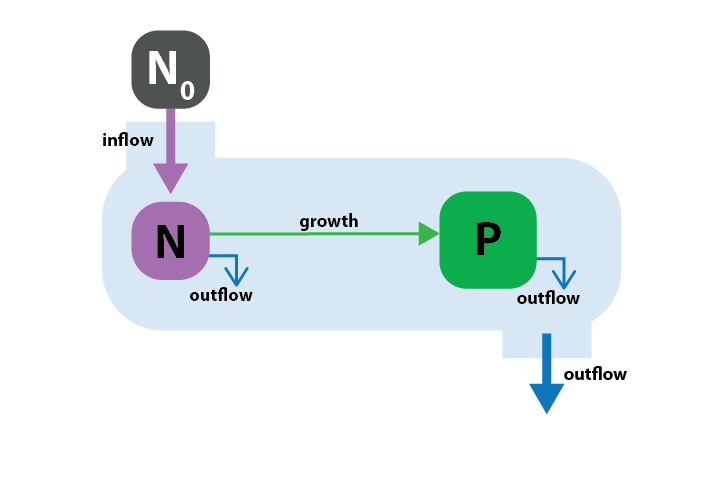

In [1]:
from IPython.display import Image
Image(filename=('images/01_schematics_Chemostat.png'), width=500)

Import necessary packages:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xso

# The model object

In [3]:
# allow relative import of local directory
import sys
sys.path.append('..')

# import the model object
from phydra.models import NPChemostat

In [4]:
# We can find out more about the model object by simply printing it to the console:
print(NPChemostat)

<xsimlab.Model (9 processes, 17 inputs)>
Core
    solver_type       [in] solver type to use for model
Time
    time_input        [in] ('time',) sequence of time for which to ...
Nutrient
    value_label       [in] label / concentration of state variable
    value_init        [in] initial value / concentration of state v...
Phytoplankton
    value_label       [in] label / concentration of state variable
    value_init        [in] initial value / concentration of state v...
N0
    forcing_label     [in] label / external nutrient
    value             [in] parameter / constant value
Inflow
    sink              [in] label reference / 
    source            [in] label reference / 
    rate              [in] parameter / linear rate of inflow
Outflow
    var_list          [in] ('d',) label list / variables flowing out
    rate              [in] parameter / linear rate of outflow
Growth
    resource          [in] label reference / 
    consumer          [in] label reference / 
    halfsat    

## Contents of model object

This shows that we have a Xarray-simlab model object (the underlying framework below XSO) with 9 processes and 16 inputs, that need to be provided at model setup.

Three of the processes are provided by the XSO backend:
- Core
- Time
- Solver
  
These processes handle solving models based on differential equations. They are included with every model built using XSO.

The other processes are our XSO components, that are included in the model:
- __Nutrient__: defines the state variable for a nutrient
- __Phytoplankton__: defines the state variable for phytoplankton
- __N0__: defines the external nutrient concentration as a model forcing
- __Inflow__: defines the linear inflow of external nutrient
- __Growth__: defines the growth of phytoplankton on the nutrient
- __Outflow__: defines the linear outflow of components within the model


For a more detailed overview of the structure and content of model components of the model, see the schematic below, and please reference the xarray-simlab-ode documentation [here](https://xarray-simlab-ode.readthedocs.io/en/latest/workflow2_variables_components.html).

In [5]:
Image(filename=('images/01_code_NPChemostat.png'), width=900)

# The model setup

This utilizes the 'xso.setup' function provided by the XSO framework. The basic parameters that need to be supplied are:
- solver: currently two choices 'odeint' or 'stepwise'
- model: this argument takes the model to be setup
- time: a numpy array 

## Table of parameters:


| Description | Symbol | Variable | Value | Units |
| --- | --- | --- | --- | --- |
| Nitrogen concentration in medium  | $N$ | `N` | t(0) = 1 | µM N|
| Phytoplankton concentration in medium | $P$ | `P` | t(0) = 0.1 | µM N |
| External nitrogen concentration | $N_0$ | `N0` | 0.1 | µM N |
| Maximum growth rate | $\mu_{max}$ | `mu_max` | 1 | $d^{-1}$ |
| Dilution rate | $d$ | `rate` | 0.1 | $d^{-1}$ |
| Half-saturation constant |  $k_N$ | `halfsat` | 0.7 | µM N |
| | | | | |
| Sinusoidal mean |  $m$ | `mean` | 1 | µM N $d^{-1}$ |
| Sinusoidal period |  $p$ | `period` | 24 | d (days) |
| Sinusoidal amplitude |  $a$ | `amplitude` | 0.5 | µM N $d^{-1}$ |


In [6]:
# below the model input dataset is created:

chemostat_setup = xso.setup(solver='solve_ivp', model=NPChemostat,
            time=np.arange(0,100, 0.1),
            input_vars={
                    # State variables
                    'Nutrient':{'value_label':'N','value_init':1.},
                    'Phytoplankton':{'value_label':'P','value_init':0.1},
                
                    # Flows:
                    'Inflow':{'source':'N0', 'rate':0.1, 'sink':'N'},
                    'Outflow':{'var_list':['N', 'P'], 'rate':0.1},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':0.7, 'mu_max':1},
                
                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.}
            })

In [7]:
print(chemostat_setup)

<xarray.Dataset>
Dimensions:                     (clock: 2, d: 2, time: 1000)
Coordinates:
  * clock                       (clock) float64 0.0 0.1
Dimensions without coordinates: d, time
Data variables: (12/17)
    Nutrient__value_label       <U1 'N'
    Nutrient__value_init        float64 1.0
    Phytoplankton__value_label  <U1 'P'
    Phytoplankton__value_init   float64 0.1
    Inflow__source              <U2 'N0'
    Inflow__rate                float64 0.1
    ...                          ...
    Growth__halfsat             float64 0.7
    Growth__mu_max              int64 1
    N0__forcing_label           <U2 'N0'
    N0__value                   float64 1.0
    Core__solver_type           <U9 'solve_ivp'
    Time__time_input            (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Attributes:
    __xsimlab_output_vars__:  Nutrient__value,Phytoplankton__value,Inflow__in...


# Executing the model

In [8]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    chemostat_out = chemostat_setup.xsimlab.run(model=NPChemostat)

             0% | initialize 

# Model output

In [9]:
print(chemostat_out)

<xarray.Dataset>
Dimensions:                     (time: 1000, d: 2, clock: 2)
Coordinates:
  * clock                       (clock) float64 0.0 0.1
  * time                        (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Dimensions without coordinates: d
Data variables: (12/23)
    Core__solver_type           <U9 'solve_ivp'
    Growth__consumer            <U1 'P'
    Growth__halfsat             float64 0.7
    Growth__mu_max              int64 1
    Growth__resource            <U1 'N'
    Growth__uptake_value        (time) float64 0.06021 0.06021 ... 0.09224
    ...                          ...
    Outflow__rate               float64 0.1
    Outflow__var_list           (d) <U1 'N' 'P'
    Phytoplankton__value        (time) float64 0.1 0.105 ... 0.9222 0.9222
    Phytoplankton__value_init   float64 0.1
    Phytoplankton__value_label  <U1 'P'
    Time__time_input            (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9


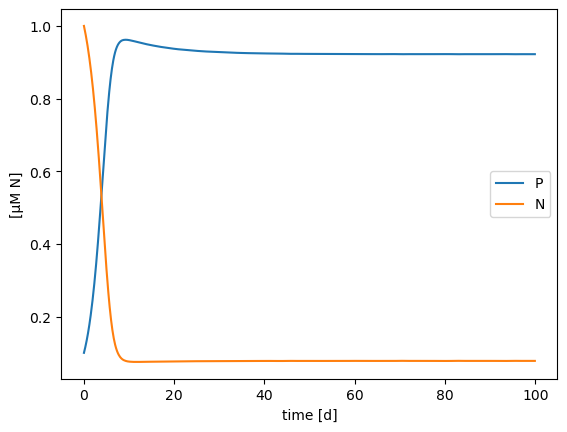

In [10]:
# quick plot:

chemostat_out.Phytoplankton__value.plot(label='P')
chemostat_out.Nutrient__value.plot(label='N')
plt.ylabel("["+chemostat_out.Phytoplankton__value.attrs['units']+"]")
plt.legend()

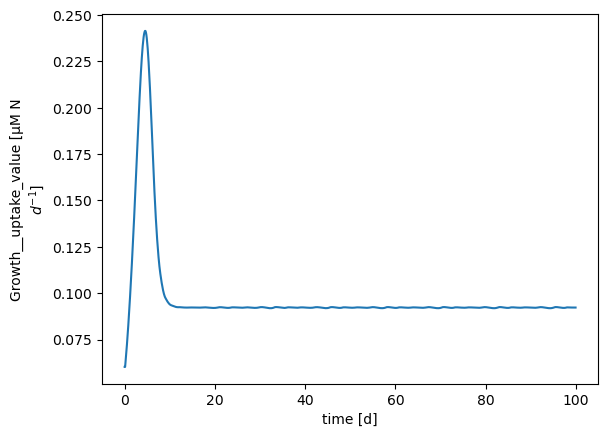

In [11]:
# values of fluxes are also stored:
chemostat_out.Growth__uptake_value.plot()

# Exchange forcing component to sinusoidal

In order to showcase the flexibility of the XSO framework, we run the same model with an external nutrient concentration that varies sinusoidally. This can be achieved via just a few lines of code:

In [12]:
## now add sinusoidal forcing:
from phydra.models.chemostat.forcings import SinusoidalExternalNutrient

# with the update_processes method we can exchange or add components
NPChemostat_sinu = NPChemostat.update_processes({'N0':SinusoidalExternalNutrient})

# utilizing the context manager (with Model:) and the update_vars method, we set up and run the modified model
with NPChemostat_sinu:
    chemostat_setup_sinu = chemostat_setup.xsimlab.update_vars(
        input_vars={'N0':{'forcing_label':'N0', 'period':24, 'mean':1, 'amplitude':0.5}})
    chemostat_out_sinu = chemostat_setup_sinu.xsimlab.run()

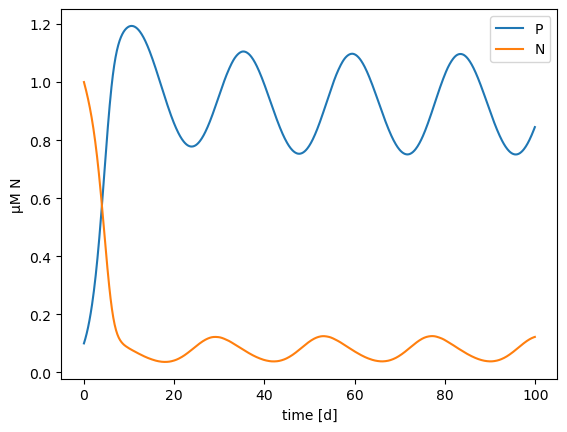

In [13]:
# quick plot #2:
chemostat_out_sinu.Phytoplankton__value.plot(label='P')
chemostat_out_sinu.Nutrient__value.plot(label='N')
plt.ylabel(chemostat_out_sinu.Phytoplankton__value.attrs['units'])
plt.legend()

## Finally let's create the exact plot shown in the publication

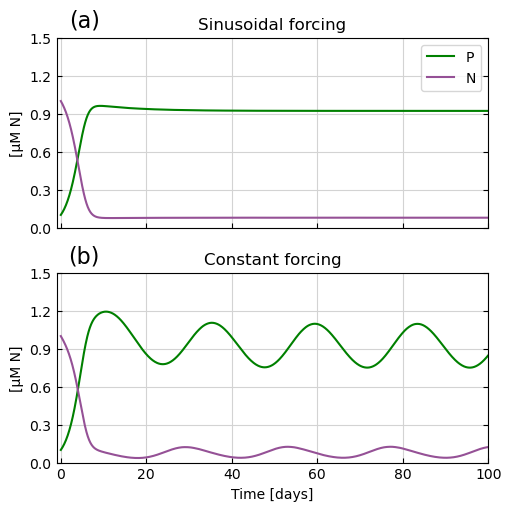

In [14]:
from matplotlib.ticker import MaxNLocator

color_dict={'N':'#955196','P':'green'}

plt.rcParams['figure.figsize'] = [5, 5]

f, ax = plt.subplots(2, 1, sharex='col', constrained_layout=True)  

for data, i, title in zip((chemostat_out, chemostat_out_sinu), (0,1), ('Sinusoidal forcing', 'Constant forcing')):
    # plot data + add labels
    data.Phytoplankton__value.plot(ax=ax[i], label='P', color=color_dict['P'])
    data.Nutrient__value.plot(ax=ax[i], label='N', color=color_dict['N'])
    ax[i].set_ylabel("["+chemostat_out_sinu.Phytoplankton__value.attrs['units']+"]")
    ax[i].set_title(title)

    # format plots
    ax[i].grid(True, color='lightgrey')
    ax[i].get_yaxis().set_major_locator(MaxNLocator(nbins=5))
    ax[i].tick_params(top=False, right=True, direction="in")


# Setting the limits for all axes.
plt.setp((ax,), xlim=(-1, 100), ylim=(0,1.5))

# format labels
f.align_ylabels()

ax[0].set_xlabel('')
ax[1].set_xlabel('Time [days]')

# show legend
ax[0].legend()

# add subplot labels
for i, label in enumerate(('(a)', '(b)')):
    ax[i].text(0.1, 1.15, label, transform=ax[i].transAxes,
      fontsize=16, fontweight='normal', va='top', ha='right')